HMP
==========

![](plots/general_illustration.png)

hmp is an open-source Python package to estimate Hidden Semi-Markov Models in a Multivariate Pattern Analysis (HsMM-MVPA) of electro-encephalographic (EEG) data based on the method developed by Anderson, Zhang, Borst, & Walsh  ([2016](https://psycnet.apa.org/doi/10.1037/rev0000030)), Borst & Anderson ([2021](http://jelmerborst.nl/pubs/ACTR_HsMM_MVPA_BorstAnderson_preprint.pdf)) and Weindel, van Maanen & Borst (in preparation).

As a summary of the method, an HsMM-MVPA analysis parses the EEG into a number of significant cognitive event (called bumps) separated by flat period reflecting the ongoing stage initiated by a bump. Hence any reaction time can then be described by the number of bumps and stage estimated using hsmm_mvpy. The important aspect of HsMM-MVPA is that it is a whole-brain analysis (or whole scalp analysis) that estimates the onset of cognitive events on a single-trial basis. This by-trial estimations allows you then to further dig into any aspect you are interested in the EEG (or MEG) signal:
- Describing an experiment or a clinical sample in terms of processes detected in the EEG signal
- Describing experimental effects based on a particular stage duration
- Estimating the effect of trial-wise manipuations (e.g. the by-trial variation of stimulus strength or the effect of time-on-task)
- Time-lock EEG signal to the onset of a given bump and perform classical ERPs or time-freauency analysis based on the events that are the estimated bumps
- And many more (e.g. evidence accumulation models on decision stage, classification based on the number of events in the signal,...)


# Documentation

The package is available through *pip* with the command ```pip install hsmm_mvpy```. 
A recommended way of using the package is to use a conda environment (see [anaconda](https://www.anaconda.com/products/distribution>) for how to install conda):

    $ conda create -n hmp 
    $ conda activate hmp
    $ conda install pip #if not already installed
    $ pip install hsmm_mvpy

Then import hsmm-mvpy in your favorite python IDE through:

```python
    import hsmm_mvpy as hmp
```

For the cutting edge version (not recommended) you can clone the repository using *git*

Open a terminal and type:

    $ git clone https://github.com/gweindel/hsmm_mvpy.git
   
Then move to the clone repository and run 
    
    $ pip install -e .

## To get started
To get started with the code:
- Check the demo below 
- Inspect the tutorials in the tutorials repository
    - Load EEG data (tutorial 1)
    - Estimating a given number of bumps (tutorial 2)
    - Test for the number of bumps that best explains the data (tutorial 3)
    - Testing differences across conditions (tutorial 4)

To further learn about the method be sure to check the paper by Anderson, Zhang, Borst, & Walsh  ([2016](https://psycnet.apa.org/doi/10.1037/rev0000030)) as well as the book chapter by Borst & Anderson ([2021](http://jelmerborst.nl/pubs/ACTR_HsMM_MVPA_BorstAnderson_preprint.pdf)). The following list also contains a non-exhaustive list of papers published using the HsMM-MVPA method:
- Berberyan, H. S., van Maanen, L., van Rijn, H., & Borst, J. (2021). EEG-based identification of evidence accumulation stages in decision-making. Journal of Cognitive Neuroscience, 33(3), 510-527. [link](https://doi.org/10.1162/jocn_a_01663)
- Van Maanen, L., Portoles, O., & Borst, J. P. (2021). The discovery and interpretation of evidence accumulation stages. Computational brain & behavior, 4(4), 395-415. [link](https://link.springer.com/article/10.1007/s42113-021-00105-2)
- Portoles, O., Blesa, M., van Vugt, M., Cao, M., & Borst, J. P. (2022). Thalamic bursts modulate cortical synchrony locally to switch between states of global functional connectivity in a cognitive task. PLoS computational biology, 18(3), e1009407. [link](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009407)

## Demo on simulated data

The following section will quickly walk you through an example usage in simulated data (using [MNE](https://mne.tools/dev/auto_examples/simulation/index.html)'s simulation functions and tutorials)

First we load the libraries necessary for the demo on simulated data

### Importing libraries

In [2]:
## Importing these packages is specific for this simulation case
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma

## Importing HMP
import hsmm_mvpy as hmp
from hsmm_mvpy import simulations

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Simulating data

In the following code block we simulate 30 trials from four known sources, this is not code you would need for your own analysis except if you want to simulate and test properties of HsM models. All these four sources are defined by a localization, an activation amplitude and a distribution (here gamma with shape and scale parameters) for the onsets of the bumps on each trial. The simulation functions are based on the [MNE tutorial ](https://mne.tools/stable/auto_examples/simulation/simulated_raw_data_using_subject_anatomy.html).

_If you're running this for the first time a 1.65 G file will be downloaded in order to perform the simulation but this will be done only once (alternatively you can just download the corresponding simulation file and place it in the same folder from where you are running this notebook)_


In [3]:
cpus = 5 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM

n_trials = 50 #Number of trials to simulate

##### Here we define the sources of the brain activity (bump) for each trial
frequency = 10.#Frequency of the bump defining its duration, half-sine of 10Hz = 50ms
amplitude = np.array([.1e-6,.1e-6,.1e-6,.1e-6,1e-20]) #Amplitude of the bump in Volt, defining signal to noise ratio
shape = 2 #shape of the gamma distribution
means = np.array([60,150, 200, 100, 80])/shape #Mean duration of the stages separating bumps, in ms
names = ['bankssts-rh','posteriorcingulate-lh','parahippocampal-lh',\
         'pericalcarine-rh','postcentral-lh']#Which source to activate at each stage (see atlas when calling simulations.available_sources())

sources = []
for source in zip(names, amplitude, means):#One source = one frequency, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency, source[1], gamma(shape, scale=source[2])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, 'dataset_README', overwrite=False)
#Recovering sampling frequency of the simulated dataset
sfreq = simulations.simulation_sfreq()
#load electrode position, specific to the simulations
positions = simulations.simulation_positions()

Simulating ./dataset_README_raw.fif


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Overwriting existing file.
Writing /home/gweindel/owncloud/projects/RUGUU/hsmm-mvpy/dataset_README_raw.fif
Closing /home/gweindel/owncloud/projects/RUGUU/hsmm-mvpy/dataset_README_raw.fif
[done]
./dataset_README_raw.fif simulated


### Creating the event structure and plotting the raw data


To recover the data we need to create the event structure based on the triggers sent during simulation. This is the same as analyzing real EEG data and recovering events in the stimulus channel. In our case 0 signal the onset of the stimulus and 5 the onset of the response. Hence a trial is defined as the times occuring between the triggers 1 and 6.

In [4]:
#Recovering the events to epoch the data (in the number of trials defined above)
generating_events = np.load(file[1])
resp_trigger = int(np.max(np.unique(generating_events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}
#Keeping only stimulus and response triggers
events = generating_events[(generating_events[:,2] == 1) | (generating_events[:,2] == resp_trigger)]#only retain stimulus and response triggers

#Visualising the raw simulated EEG data
import mne
raw = mne.io.read_raw_fif(file[0], preload=False, verbose=False)
raw.pick_types(eeg=True).plot(scalings=dict(eeg=1e-5), events=events, block=True);

Using qt as 2D backend.
Channels marked as bad:
none


### Recovering number of sources as well as actual by-trial variation

To compare the by-trial duration of bumps that we will estimate later on we first recover the actual number of sources used in the simulation as well as the actual by-trial variation in the onset of the bumps. Again with a typical dataset you wouldn't need that part as you ignore the ground truth

In [5]:
%matplotlib inline
number_of_sources = len(np.unique(generating_events[:,2])[1:])#one trigger = one source
#Recover the actual time of the simulated bumps
random_source_times = np.reshape(np.ediff1d(generating_events[:,0],to_begin=0)[generating_events[:,2] > 1], \
           (n_trials, number_of_sources))

## Demo of the HsMM Code for a single participant in a single condition based on the simulated data

First we read the EEG data as we would for a single participant:

In [6]:
# Reading the data
eeg_data = hmp.utils.read_mne_EEG(file[0], event_id, resp_id, sfreq, 
            events_provided=events, verbose=False)


Processing participant ./dataset_README_raw.fif
Reading 0 ... 142583  =      0.000 ...   237.395 secs...
Creating epochs based on following event ID :[1 6]
N trials without response event: 0
Applying reaction time trim to keep RTs between 0.001 and 5 seconds
50 RTs kept of 50 clean epochs
50 trials were retained for participant ./dataset_README_raw.fif
End sampling frequency is 600.614990234375 Hz


The package uses [xarray](https://docs.xarray.dev/en/stable/) named dimension matrices, allowing to directly manipulate the data using the name of the dimensions:

<xarray.Dataset>
Dimensions:      (participant: 1, epochs: 50, electrodes: 59, samples: 843)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * electrodes   (electrodes) <U7 'EEG 001' 'EEG 002' ... 'EEG 059' 'EEG 060'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 836 837 838 839 840 841 842
  * participant  (participant) <U2 'S0'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 2.469e-06...
    event        (participant, epochs) <U8 'stimulus' 'stimulus' ... 'stimulus'
Attributes:
    sfreq:    600.614990234375
    offset:   0


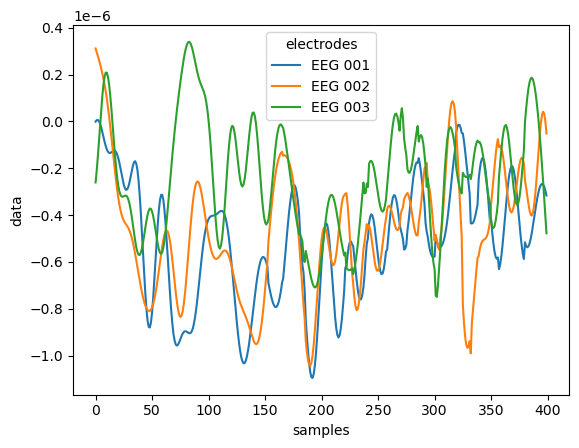

In [7]:
#example of usage of xarray
print(eeg_data)
eeg_data.sel(electrodes=['EEG 001','EEG 002','EEG 003'], samples=range(400))\
    .data.groupby('samples').mean(['participant','epochs']).plot.line(hue='electrodes');

Next we transform the data as in Anderson, Zhang, Borst, & Walsh  ([2016](https://psycnet.apa.org/doi/10.1037/rev0000030)) including standardization of individual variances (not in this case as we have only one simulated participant), z-scoring and spatial principal components analysis (PCA). 

Note that if the number of components to retain is not specified, the scree plot of the PCA is displayed and a prompt ask how many PCs should be retained (in this case we specify it as building the README does not allow for prompts)

In [8]:
hsmm_dat = hmp.utils.transform_data(eeg_data.data, apply_standard=False, n_comp=4)

# Estimating an HsMM model

We can directly fit an HsMM model without giving any info on the number of bumps (see tutorial 2 for the explanation of the following cell)

In [15]:
%%time
init = hmp.models.hsmm(hsmm_dat, eeg_data, bump_width=50, cpus=cpus)#Initialization of the model
estimates = init.fit(step=10, verbose=False)

  0%|          | 0/360 [00:00<?, ?it/s]

CPU times: user 827 ms, sys: 3.22 ms, total: 830 ms
Wall time: 828 ms


### Visualizing results of the fit

In the previous cell we initiated an HsMM model looking for 50ms bumps in the EEG signal and parsing the EEG data into a signal with 4 bumps and 5 gamma distributed stages with a fixed shape of 2 and a scale estimated by stage. We can now inspect the results of the fit

We can directly take a look to the topologies and latencies of the bumps by calling ```hmp.visu.plot_topo_timecourse```

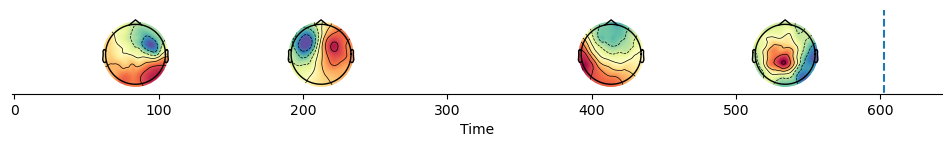

In [16]:
hmp.visu.plot_topo_timecourse(eeg_data, estimates, #Data and estimations 
                               positions, init,#position of the electrodes and initialized model
                               magnify=1, sensors=False, time_step=1000/init.sfreq,#Display control parameters
                               times_to_display = np.mean(init.ends - init.starts))#plot reaction times

This shows us the electrode activity on the scalp as well as the average time of occurence of the bump based on the stage distributions.

As we are estimating the bump onsets on a by-trial basis we can look at the by-trial variation in stage duration.

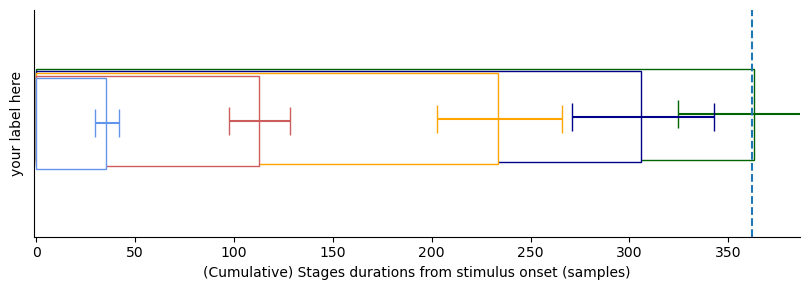

In [17]:
bump_times_estimates = init.compute_times(init, estimates, mean=False, add_rt=True).dropna('bump')#computing predicted bump times
ax = hmp.visu.plot_latencies_average(bump_times_estimates, init.bump_width_samples, 1, errs='ci', times_to_display = np.mean(init.ends - init.starts))
ax.set_ylabel('your label here');

For the same reason we can also inspect the probability distribution of bump onsets:

<AxesSubplot: xlabel='Time (in samples)', ylabel='p(event)'>

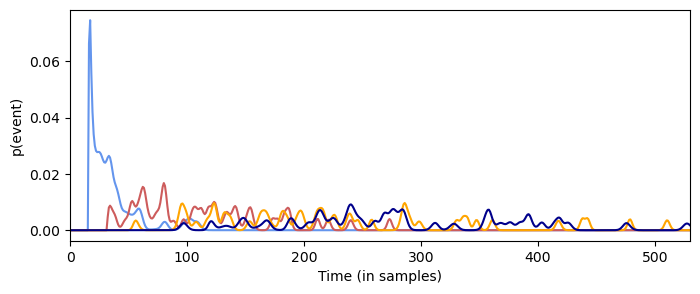

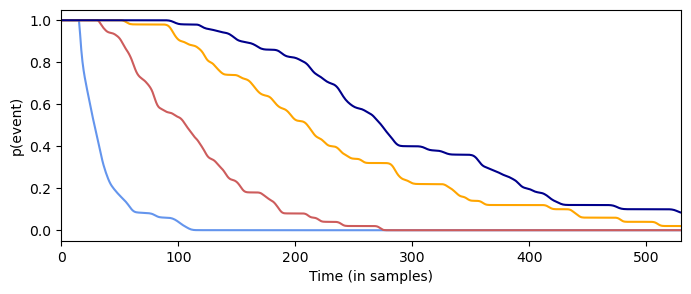

In [18]:
hmp.visu.plot_distribution(estimates.eventprobs.mean(dim=['trial_x_participant']), xlims=(0,np.percentile(random_source_times.sum(axis=1), q=90)))
hmp.visu.plot_distribution(estimates.eventprobs.mean(dim=['trial_x_participant']), xlims=(0,np.percentile(random_source_times.sum(axis=1), q=90)), survival=True)

As HsMM-MVPA selected those bumps onset per trial we can also look at the predicted bump onsets for a single trial

<AxesSubplot: xlabel='Time (in samples)', ylabel='p(event)'>

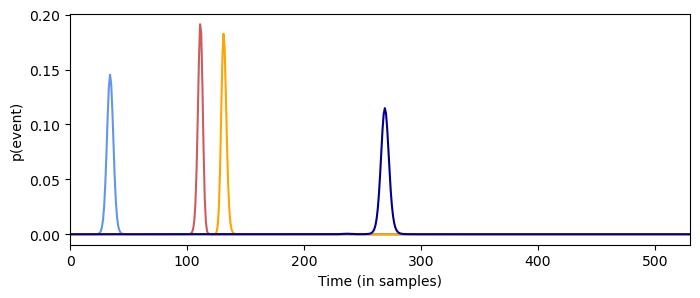

In [19]:
hmp.visu.plot_distribution(estimates.eventprobs.sel(trial_x_participant=('S0', 1)), 
                            xlims=(0,np.percentile(random_source_times.sum(axis=1), q=90)))

This then shows the likeliest bump location in time for the first trial!

## Comparing with ground truth

As we simulated the data we have access to the ground truth of the underlying generative events. We can then compare the average stage durations compared to the one estimated by HsMM-MVpy. As in the beginning, this code is specific to the case where you simulate data.

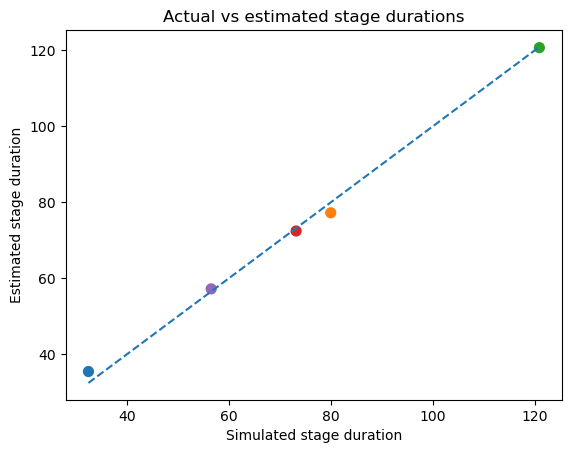

In [20]:
colors = sns.color_palette(None, number_of_sources)
# plt.scatter(np.mean(random_source_times, axis=0), estimates.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)]), color=colors,s=50)
plt.scatter(np.mean(random_source_times, axis=0), estimates.parameters.dropna('stage').isel(parameter=1)*2, color=colors,s=50)
plt.plot([np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],
         [np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],'--');
plt.title('Actual vs estimated stage durations')
plt.xlabel('Simulated stage duration')
plt.ylabel('Estimated stage duration')
plt.show()


Or also overlay actual bumps onset with predicted one

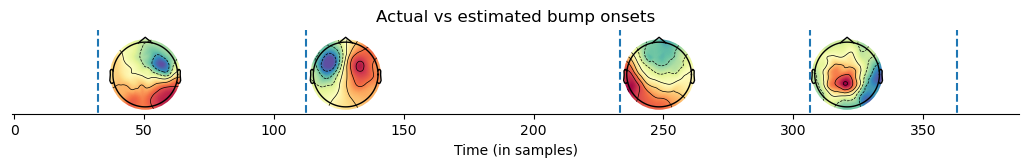

In [21]:
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, magnify=1, sensors=False, figsize=(13,1), title='Actual vs estimated bump onsets',
        times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

We see that the HsMM-MVpy package recovers the exact average location of the bumps defined in the simulated data

We can further test how well the package did by comparing the generated single trial onsets with those estimated from the HsMM model

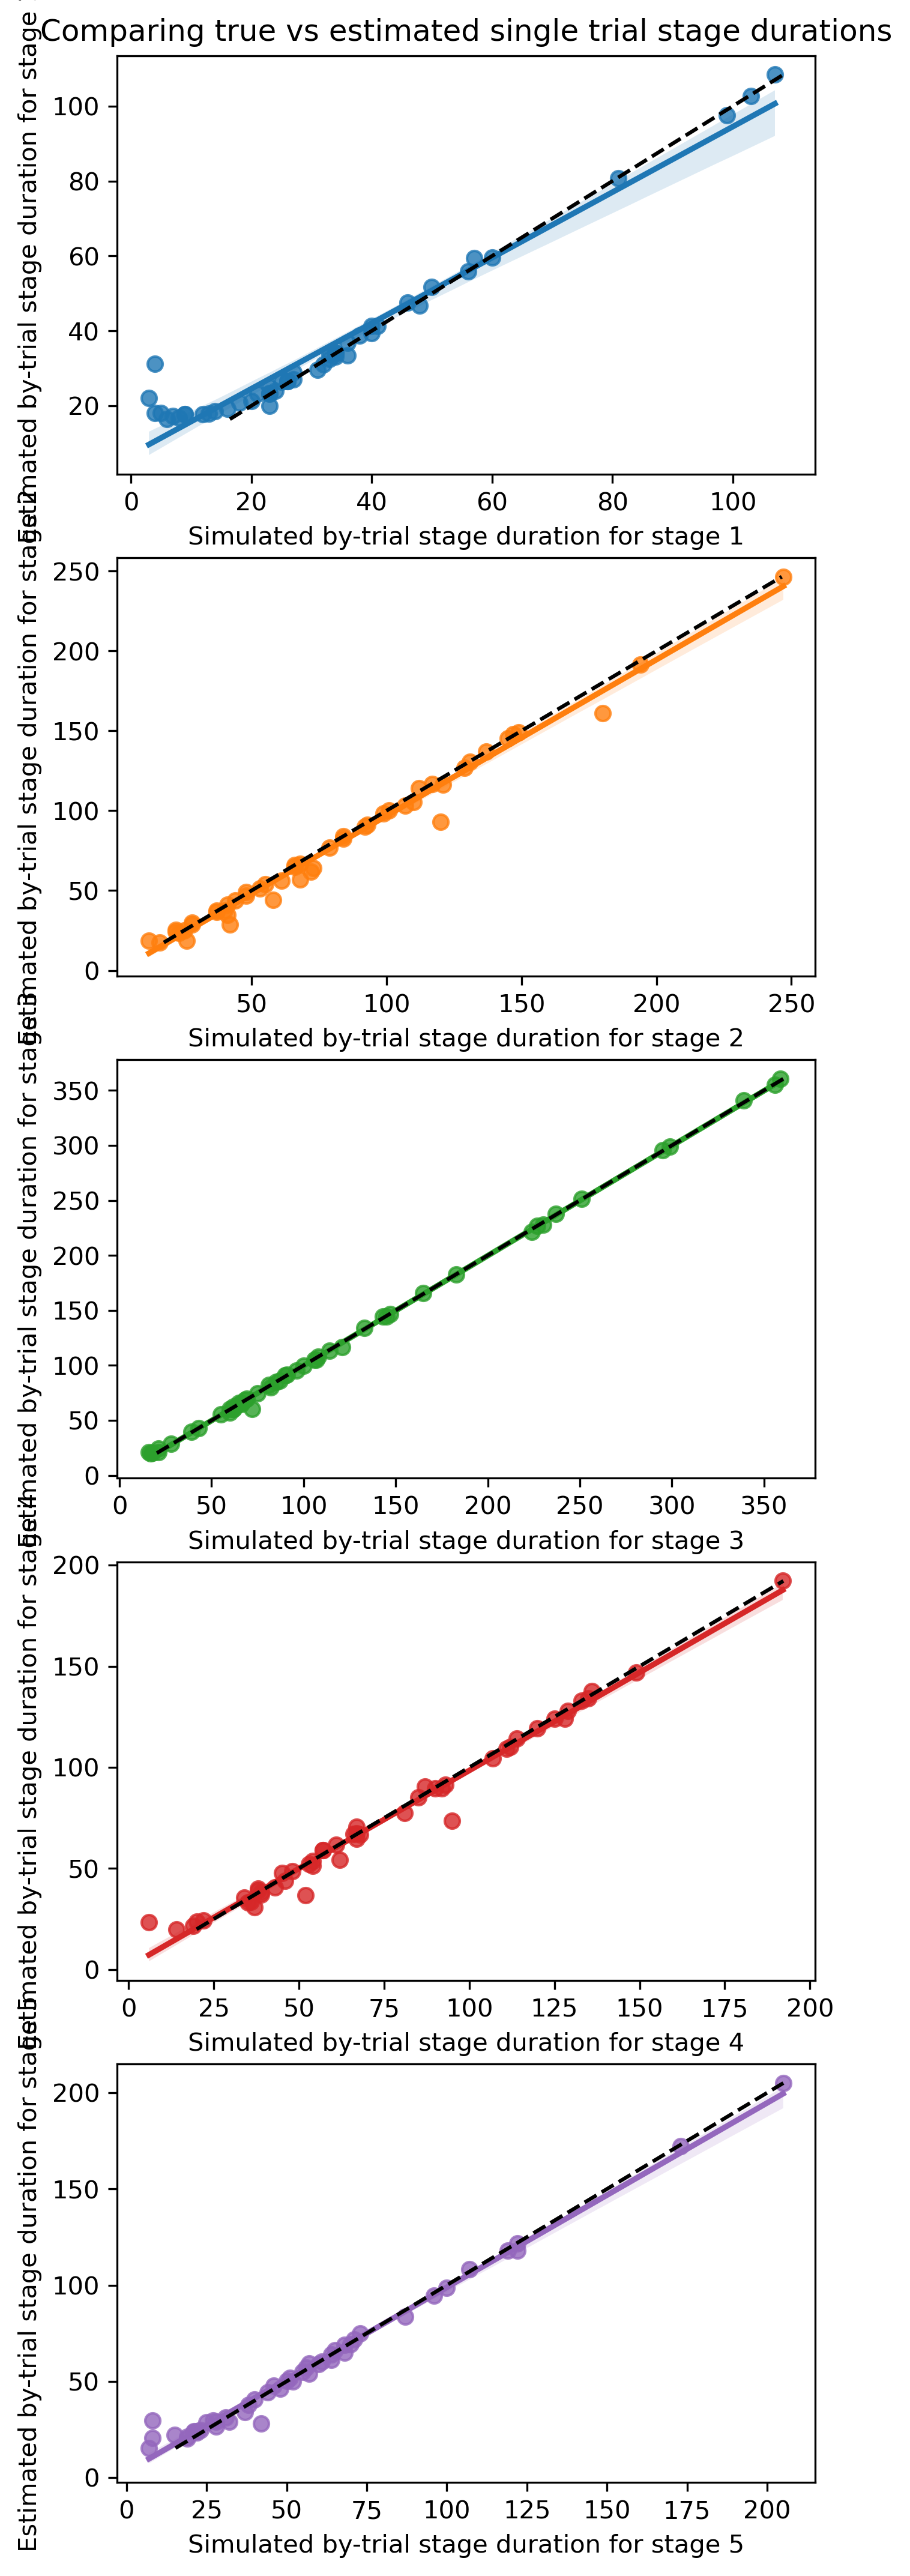

In [22]:
fig, ax= plt.subplots(number_of_sources,1, figsize=(5,3.5*number_of_sources), dpi=300)
ax[0].set_title('Comparing true vs estimated single trial stage durations')
i = 0

for bump in init.compute_times(init, estimates, duration=True, mean=False, add_rt=True).T:
    sns.regplot(x=random_source_times[:,i].T, y=bump, ax=ax[i], color=colors[i])
    ax[i].plot([np.min(bump), np.max(bump)], [np.min(bump), np.max(bump)],'--', color='k')
    ax[i].set_ylabel(f'Estimated by-trial stage duration for stage {i+1}')
    ax[i].set_xlabel(f'Simulated by-trial stage duration for stage {i+1}')
    i+= 1

We see that every stage gets nicely recovered even on a by-trial basis!

# Beyond summary statistics for EEG analysis

Now the purpose, apart from determining the number and timecourse of important EEG events in the Rreaction time, is also to use the by-trial information.

We illustrate this by first plotting the traditional event-related potentials (i.e. taking the average of given electrodes across the different time points) with cherry-picked electrodes.

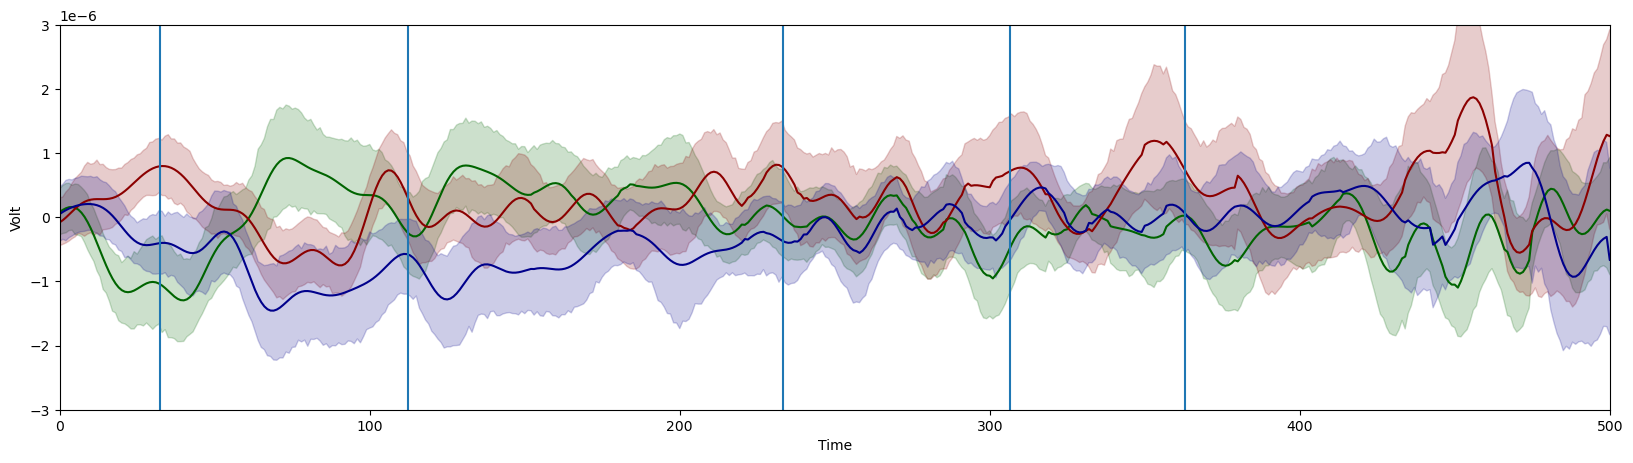

In [23]:
import seaborn as sns
import pandas as pd

data = eeg_data.stack({'trial_x_participant':['participant','epochs']}).data.dropna('trial_x_participant', how="all")
fig, ax = plt.subplots(1,1, figsize=(20,5), sharey=True)

for electrode in zip(['EEG 016','EEG 025','EEG 020'],#Cherry-picked electrodes
                     ['darkgreen','darkred','darkblue']):
    df = pd.DataFrame(data.sel(electrodes=electrode[0]).squeeze().T).melt(var_name='Time')
    sns.lineplot(x='Time', y='value',data=df, color=electrode[1])

plt.vlines(np.cumsum(random_source_times.mean(axis=0)), -3e-6, 3e-6)
plt.ylabel('Volt')
plt.xlim(0,500)
plt.ylim(-3e-6,3e-6);


Given how variable and serial each of these stages are, the more you progress in the chain of events the less clear the signal gets. This is very close to trqditional ERPs with very clear signal in the beginning of a trial (as events are more in sync) and summed and blurried in later stages of the reaction times (as event are off sync).

Now things can get better if we first parse, by-trial, the signal into the different stages based on the HsMM estimates:

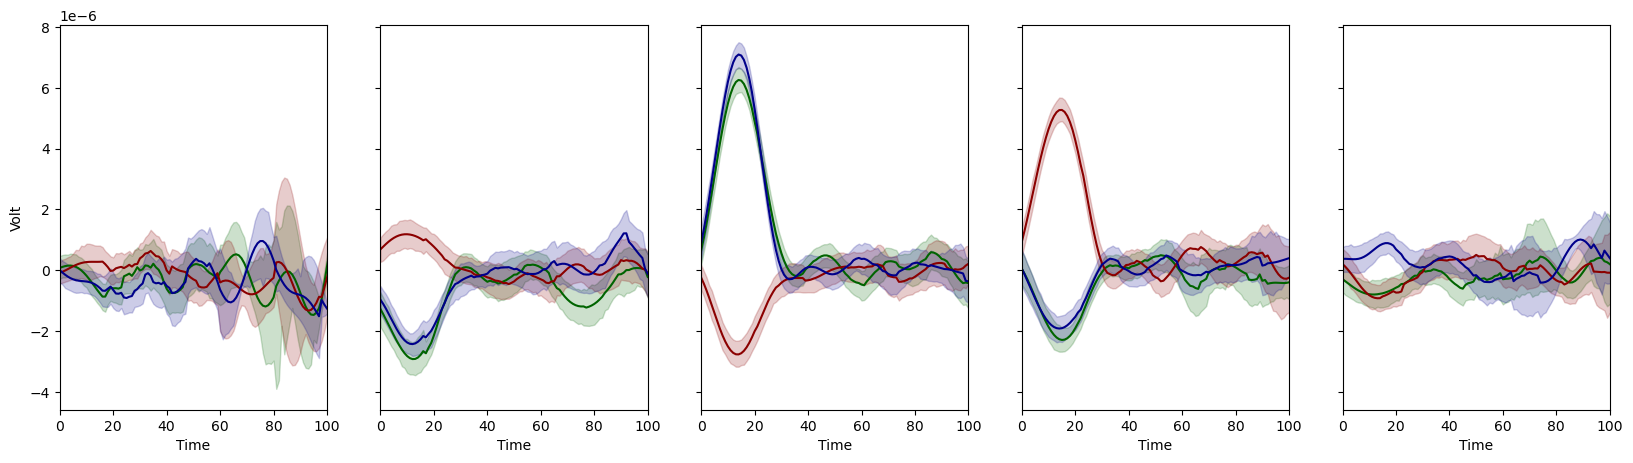

In [24]:
BRP_times = init.compute_times(init, estimates.dropna('bump'), fill_value=0, add_rt=True)

fig, ax = plt.subplots(1,number_of_sources, figsize=(20,5), sharey=True, sharex=True)
ax[0].set_ylabel('Volt')
for stage in range(number_of_sources):
    BRP = hmp.utils.event_times(data, BRP_times,'EEG 016',stage=stage)
    df = pd.DataFrame(BRP).melt(var_name='Time')
    sns.lineplot(x="Time", y="value", data=df,ax=ax[stage], color='darkgreen')
    BRP = hmp.utils.event_times(data, BRP_times,'EEG 025',stage=stage)
    df = pd.DataFrame(BRP).melt(var_name='Time')
    sns.lineplot(x="Time", y="value", data=df,ax=ax[stage], color='darkred')
    BRP = hmp.utils.event_times(data, BRP_times,'EEG 032',stage=stage)
    df = pd.DataFrame(BRP).melt(var_name='Time')
    sns.lineplot(x="Time", y="value", data=df,ax=ax[stage], color='darkblue') 
    plt.xlim(0,100)

In this case we clearly see at each stage the half-sin (of 50ms hence ~ 30 samples for the sampling frequency used) we simulated in the first step and the preceding period of silence (hence the first stage doesn't contain such a half-sin). Note that the end of the stages tend to be noisier because less trial are defining the average signal (also why the confidence interval grows).


### Follow-up

For examples on how to use the package when the number of bumps are unkown, or to compare stage durations across conditions see the tutorial notebooks:
- Load EEG data (tutorial 1)
- Estimating a given number of bumps (tutorial 2)
- Test for the number of bumps that best explains the data (tutorial 3)
- Testing differences across conditions (tutorial 4)